In [ ]:
# Section 1: Setup and Libraries

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd
from itertools import cycle
import os
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict
import random
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedKFold
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set the theme for seaborn
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# HF Token (add your HF token here)
from huggingface_hub import login  # Import the login function from Hugging Face Hub

# Authenticate with Hugging Face
hf_token = os.getenv("HF_TOKEN")  # Retrieve the Hugging Face token from environment variables
login(token=hf_token)  # Log in to Hugging Face using the token


In [ ]:
# Section 2: Google Drive Setup and Data Loading

# Mount Google Drive to access data
drive.mount('/content/drive')

# Set the path to the TESI directory in Google Drive
tesi_path = '/content/drive/My Drive/TESI'
os.chdir(tesi_path)  # Change the working directory
print("Current working directory:", os.getcwd())

# Load the Pickle file containing the dataset
import pickle
file_path = '/content/drive/MyDrive/TESI/newdata_updated.pkl'

with open(file_path, 'rb') as f:
    newdata = pickle.load(f)

print("Pickle file loaded successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/My Drive/TESI
Pickle file loaded successfully.


In [ ]:
def print_updrs_distribution(data, label_key='label', updrs_keys=['updrs', 'UPDRS']):
    """
    Prints the distribution of data based on UPDRS levels and labels.

    Args:
        data (list): Dataset containing 'label' and 'updrs' or 'UPDRS' information.
        label_key (str): Key for the label (0 = control, 1 = Parkinsonian).
        updrs_keys (list): Possible keys for the UPDRS value in the data.
    """
    # Counters for labels and UPDRS
    updrs_counts = defaultdict(int)
    control_count, parkinsonian_count = 0, 0

    for item in data:
        # Check for the presence of the label key
        if label_key in item:
            label = item[label_key]
            if label == 0:
                control_count += 1
            elif label == 1:
                parkinsonian_count += 1

        # Check for the presence of at least one UPDRS key
        updrs_value = None
        for key in updrs_keys:
            if key in item:
                updrs_value = item[key]
                break

        # Increment the count for the UPDRS level
        if updrs_value is not None:
            updrs_counts[updrs_value] += 1

    # Print results
    print(f"Number of controls: {control_count}")
    print(f"Number of Parkinsonians: {parkinsonian_count}")
    print("UPDRS Distribution:")
    for updrs_value, count in sorted(updrs_counts.items()):
        print(f"  UPDRS {updrs_value}: {count}")

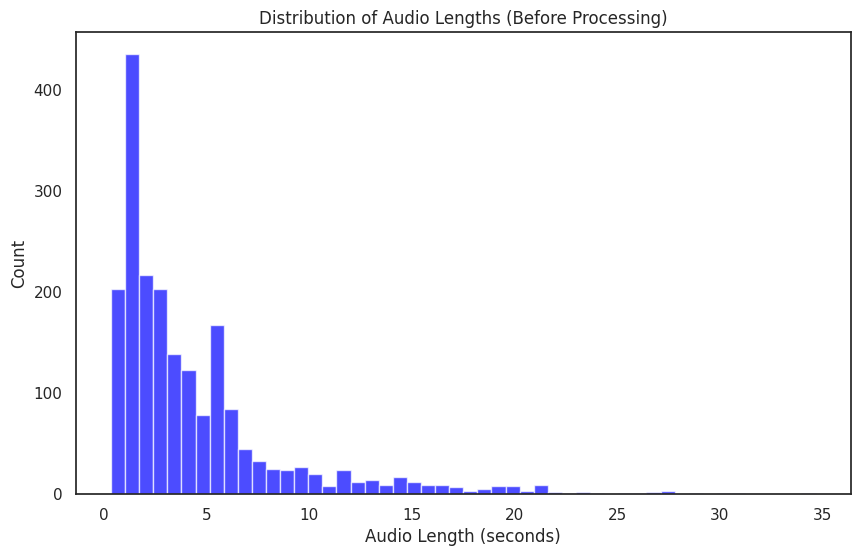

Number of audios: 1997
Minimum audio length: 0.36 seconds
Maximum audio length: 34.66 seconds


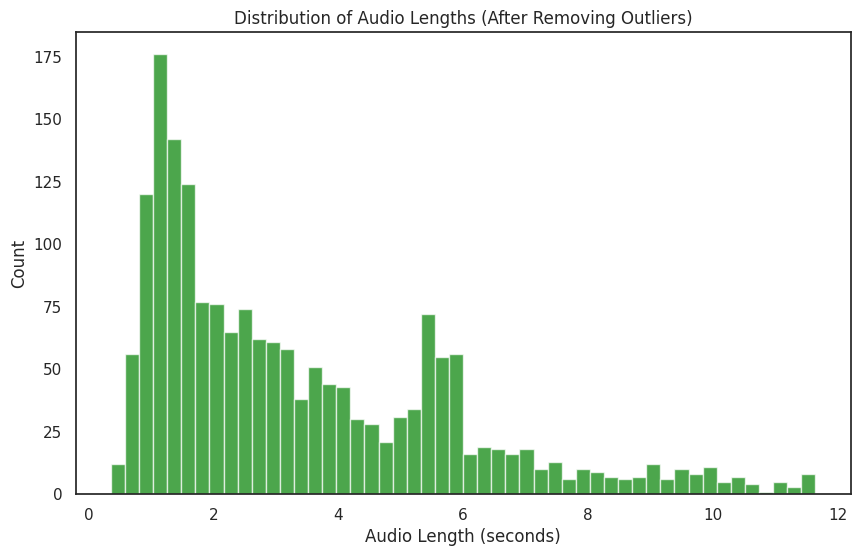

Number of audios after removing outliers: 1841
Minimum audio length after filtering: 0.36 seconds
Maximum audio length after filtering: 11.64 seconds
The shortest audio length is: 0.36 seconds (15872 samples)
Distribution BEFORE outlier removal:
Number of controls: 966
Number of Parkinsonians: 1031
UPDRS Distribution:
  UPDRS 0: 118
  UPDRS 1: 98
  UPDRS 2: 65
  UPDRS 3: 5
  UPDRS 4: 20
Distribution AFTER outlier removal:
Number of controls: 918
Number of Parkinsonians: 923
UPDRS Distribution:
  UPDRS 0: 73
  UPDRS 1: 69
  UPDRS 2: 38
  UPDRS 3: 5
  UPDRS 4: 19
Preprocessing audios...


In [ ]:
# Define the standard audio sampling rate
sampling_rate = 44100  # 44.1 kHz

# Calculate audio lengths in samples and convert to seconds
audio_lengths = [len(item['audio']) for item in newdata]
audio_lengths_sec = [length / sampling_rate for length in audio_lengths]

# Plot the distribution of audio lengths before processing
plt.figure(figsize=(10, 6))
plt.hist(audio_lengths_sec, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Audio Lengths (Before Processing)')
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Count')
plt.show()

# Print statistics about the audio lengths
print(f"Number of audios: {len(audio_lengths_sec)}")
print(f"Minimum audio length: {min(audio_lengths_sec):.2f} seconds")
print(f"Maximum audio length: {max(audio_lengths_sec):.2f} seconds")

# Remove outliers based on audio length using the Interquartile Range (IQR) method
q1 = np.percentile(audio_lengths, 25)
q3 = np.percentile(audio_lengths, 75)
iqr = q3 - q1

# Define acceptable range for audio lengths
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter audios within the acceptable range
filtered_data = [item for item in newdata if lower_bound <= len(item['audio']) <= upper_bound]

# Extract lengths after filtering
filtered_audio_lengths = [len(item['audio']) for item in filtered_data]
filtered_audio_lengths_sec = [length / sampling_rate for length in filtered_audio_lengths]

# Plot the distribution after filtering
plt.figure(figsize=(10, 6))
plt.hist(filtered_audio_lengths_sec, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Audio Lengths (After Removing Outliers)')
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Count')
plt.show()

# Print statistics after filtering
print(f"Number of audios after removing outliers: {len(filtered_audio_lengths_sec)}")
print(f"Minimum audio length after filtering: {min(filtered_audio_lengths_sec):.2f} seconds")
print(f"Maximum audio length after filtering: {max(filtered_audio_lengths_sec):.2f} seconds")

# Find the shortest audio length (n) in samples
min_length = min(filtered_audio_lengths)
print(f"The shortest audio length is: {min_length / sampling_rate:.2f} seconds ({min_length} samples)")

# Before removing outliers
print("Distribution BEFORE outlier removal:")
print_updrs_distribution(newdata)

# After removing outliers
print("Distribution AFTER outlier removal:")
print_updrs_distribution(filtered_data)


# Update 'newdata' to 'filtered_data' for further processing
newdata = filtered_data
# Preprocess the audios by trimming to the central part
print("Preprocessing audios...")
min_length = min([len(item['audio']) for item in newdata])
for item in newdata:
    audio_trimmed = item['audio']
    start = (len(audio_trimmed) - min_length) // 2
    end = start + min_length
    item['audio'] = audio_trimmed[start:end]  # Trim audio



Creating Mel-Spectrograms...


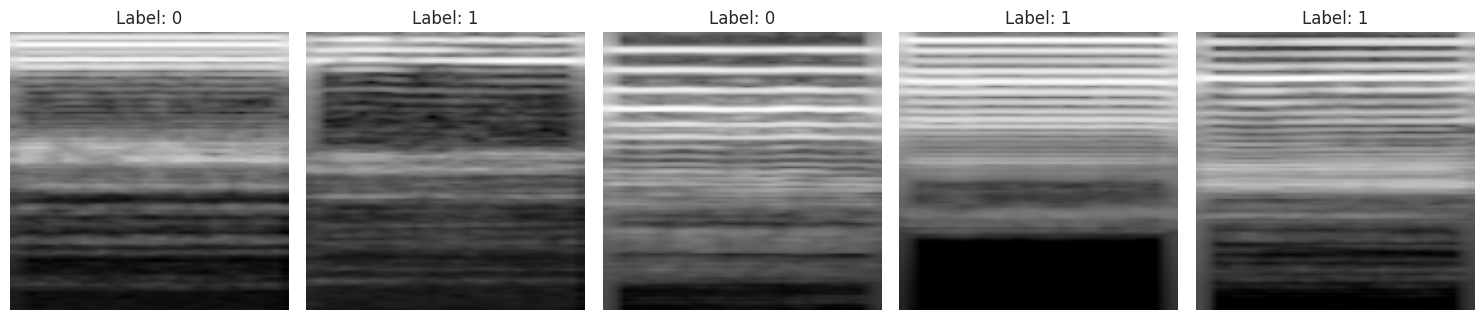

In [ ]:
# Section 4: Mel-Spectrogram Creation and RGB Conversion

import random
import matplotlib.pyplot as plt

# Create Mel-Spectrogram for each audio
print("Creating Mel-Spectrograms...")
for item in newdata:
    audio = np.array(item['audio'])
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=44100)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    item['audio'] = mel_spectrogram_db  # Replace with Mel-Spectrogram

# Convert Mel-Spectrogram to RGB
def convert_to_rgb(mel_spec):
    resized_mel_spec = cv2.resize(mel_spec, (224, 224))  # Resize to 224x224
    resized_mel_spec = (resized_mel_spec - np.min(resized_mel_spec)) / (np.max(resized_mel_spec) - np.min(resized_mel_spec))  # Normalize
    return np.stack([resized_mel_spec] * 3, axis=-1)  # Convert to 3-channel RGB

# Convert all Mel-Spectrograms to RGB
for item in newdata:
    item['audio'] = convert_to_rgb(item['audio'])  # Convert each Mel-Spectrogram to RGB

# Function to plot 5 random Mel-Spectrograms with their labels
def plot_random_mel_spectrograms(data, num_samples=5):
    random_samples = random.sample(data, num_samples)  # Get 5 random samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))  # Create subplots

    for i, sample in enumerate(random_samples):
        mel_rgb = sample['audio']  # Get the Mel-Spectrogram in RGB
        label = sample['label']  # Get the label

        axes[i].imshow(mel_rgb)  # Plot the spectrogram
        axes[i].set_title(f"Label: {label}")  # Set the title with the label
        axes[i].axis('off')  # Hide axis for cleaner look

    plt.tight_layout()
    plt.show()

# Plot 5 random Mel-Spectrograms with their labels
plot_random_mel_spectrograms(newdata, num_samples=5)


In [ ]:
# Section 5: Dataset and DataLoader Preparation

class AudioDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data: Lista di campioni (dizionari) contenenti 'audio', 'label', e metadati come 'updrs'.
            transform: Trasformazioni da applicare ai dati (es. normalizzazione, data augmentation).
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Args:
            idx: Indice del campione.
        Returns:
            image: Dati audio trasformati (es. Mel-spectrogram).
            label: Etichetta corrispondente (0 o 1).
            metadata: Dizionario contenente metadati, come UPDRS.
        """
        sample = self.data[idx]
        image = sample['audio']
        label = sample['label']

        # Controlla se esistono le chiavi 'updrs' o 'UPDRS'
        if 'updrs' in sample:
            updrs_value = sample['updrs']
        elif 'UPDRS' in sample:
            updrs_value = sample['UPDRS']
        else:
            updrs_value = -1  # Assegna -1 se nessuna chiave è presente

        metadata = {'updrs': updrs_value}

        if self.transform:
            image = self.transform(image)

        return image, label, metadata

# Define data augmentation and normalization transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10)
])

# Group the data by subject ID and label (for balancing)
grouped_by_id = defaultdict(list)
for item in newdata:
    grouped_by_id[item['id']].append(item)

# List all subject IDs
all_ids = list(grouped_by_id.keys())


In [ ]:
def analyze_updrs(val_loader, model, device):
    """
    Analyze logits and probabilities by UPDRS levels.
    Args:
        val_loader: Validation data loader.
        model: Trained model.
        device: Device (CPU or GPU).
    Returns:
        updrs_results: Dictionary with logits, probabilities, and true labels grouped by UPDRS levels.
    """
    updrs_results = {0: [], 1: [], 2: [], 3: [], 4: []}

    # Validation phase: Calculate logits and probabilities for each UPDRS level
    with torch.no_grad():
        for inputs, labels, metadata in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits

            # Calculate probabilities and logits
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probability of being Parkinsonian
            logits = outputs[:, 1]  # Logit for Parkinsonian class

            for i, prob in enumerate(probabilities.cpu().numpy()):
                logit = logits[i].item()
                updrs_value = metadata['updrs'][i]  # Access UPDRS metadata

                if isinstance(updrs_value, torch.Tensor):
                    updrs_value = updrs_value.item()
                if updrs_value != -1:  # Skip invalid UPDRS values
                    updrs_results[int(updrs_value)].append((logit, prob, labels[i].item()))

    return updrs_results




In [ ]:
def aggregate_updrs_results(fold_results):
    """
    Aggregates UPDRS results across all folds.

    Args:
        fold_results (list): List of dictionaries, where each dictionary contains
                             'updrs_results' for a fold.

    Returns:
        aggregated_results (dict): Dictionary with aggregated metrics for each UPDRS level.
                                   Keys: {0, 1, 2, 3, 4}
                                   Values: Dict with:
                                       - 'total_count': Total samples with this UPDRS level.
                                       - 'mean_probability': Mean probability for Parkinsonian classification.
                                       - 'mean_logit': Mean logit value for Parkinsonian class.
                                       - 'percentage_classified_as_parkinsonian': Percentage classified as Parkinsonian.
        probabilities_by_updrs (dict): Dictionary containing all individual probabilities for each UPDRS level.
    """
    # Initialize results dictionary for each UPDRS level
    aggregated_results = {0: [], 1: [], 2: [], 3: [], 4: []}
    probabilities_by_updrs = {0: [], 1: [], 2: [], 3: [], 4: []}

    # Collect all results from all folds
    for fold in fold_results:
        updrs_results = fold['updrs_results']
        for level, values in updrs_results.items():
            aggregated_results[level].extend(values)  # Combine results across folds
            probabilities_by_updrs[level].extend([prob for _, prob, _ in values])  # Collect probabilities

    # Calculate aggregated metrics
    metrics = {}
    for level, results in aggregated_results.items():
        if results:
            # Extract logits, probabilities, and true labels
            logits, probs, true_labels = zip(*results)
            mean_prob = np.mean(probs)  # Mean probability
            mean_logit = np.mean(logits)  # Mean logit value
            total_count = len(results)  # Total count for this UPDRS level
            classified_as_parkinsonian = sum(1 for prob, label in zip(probs, true_labels) if prob >= 0.5 and label == 1)
            percentage_classified_as_parkinsonian = (classified_as_parkinsonian / total_count) * 100

            # Store metrics
            metrics[level] = {
                'total_count': total_count,
                'mean_probability': mean_prob,
                'mean_logit': mean_logit,
                'percentage_classified_as_parkinsonian': percentage_classified_as_parkinsonian,
            }
        else:
            # Handle cases with no data for this UPDRS level
            metrics[level] = {
                'total_count': 0,
                'mean_probability': 0.0,
                'mean_logit': 0.0,
                'percentage_classified_as_parkinsonian': 0.0,
            }

    return metrics, probabilities_by_updrs




In [ ]:
# Section 6: Balanced Data Splitting Function

def stratified_group_split(all_ids, grouped_by_id, label_key='label'):
    # Split into Parkinson's and control groups
    controls = [id_ for id_ in all_ids if grouped_by_id[id_][0][label_key] == 0]
    parkinsons = [id_ for id_ in all_ids if grouped_by_id[id_][0][label_key] == 1]

    random.shuffle(controls)
    random.shuffle(parkinsons)

    split_controls = len(controls) // 5
    split_parkinsons = len(parkinsons) // 5

    folds = []
    for i in range(5):
        fold_controls = controls[i * split_controls:(i + 1) * split_controls]
        fold_parkinsons = parkinsons[i * split_parkinsons:(i + 1) * split_parkinsons]
        folds.append(fold_controls + fold_parkinsons)

    return folds


In [ ]:
# Section 7: Model Configuration and Cross-Validation

# Hyperparameters
num_epochs = 300  # Number of epochs
batch_size = 64   # Batch size
early_stopping_patience = 30  # Patience for early stopping
learning_rate = 0.001  # Initial learning rate

# K-Fold Cross-Validation setup
print("Starting K-Fold Cross Validation...")
folds = stratified_group_split(all_ids, grouped_by_id)  # Generate stratified folds

# Lists to store metrics across folds
fold_results = []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []
train_losses, val_losses = [], []

# Cross-validation loop
for fold, val_ids in enumerate(folds):
    print(f'\nFOLD {fold + 1}')

    # Prepare training and validation IDs
    train_ids = [id_ for id_ in all_ids if id_ not in val_ids]
    train_samples = [item for id_soggetto in train_ids for item in grouped_by_id[id_soggetto]]
    val_samples = [item for id_soggetto in val_ids for item in grouped_by_id[id_soggetto]]

    # Get labels for each set
    train_labels = [item['label'] for item in train_samples]
    val_labels = [item['label'] for item in val_samples]

    # Print training and validation set statistics
    print(f"Training set: {len(train_samples)} samples - Controls: {train_labels.count(0)}, Parkinson's: {train_labels.count(1)}")
    print(f"Validation set: {len(val_samples)} samples - Controls: {val_labels.count(0)}, Parkinson's: {val_labels.count(1)}")

    # Create datasets and data loaders
    train_dataset = AudioDataset(train_samples, transform=data_transforms)
    val_dataset = AudioDataset(val_samples, transform=data_transforms)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

      # Initialize and configure the model
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)

    # Freezing all layers except the classifier
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers initially
    for param in model.classifier.parameters():
        param.requires_grad = True  # Unfreeze the classifier head

    # Set up device, loss function, optimizer, and learning rate scheduler
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

    # Initialize training variables
    best_val_accuracy = 0
    patience_counter = 0
    epoch_train_accuracies, epoch_val_accuracies = [], []
    epoch_train_precisions, epoch_val_precisions = [], []
    epoch_train_recalls, epoch_val_recalls = [], []
    epoch_train_f1s, epoch_val_f1s = [], []
    epoch_train_losses, epoch_val_losses = [], []
    val_fold_preds, val_fold_true = [], []

    # Training loop for the current fold
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        train_loss, correct_train = 0.0, 0
        train_preds, train_true = [], []

        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_train += torch.sum(preds == labels).item()
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())

        # Calculate and store training metrics
        train_loss /= len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)
        train_precision = precision_score(train_true, train_preds, zero_division=0)
        train_recall = recall_score(train_true, train_preds)
        train_f1 = f1_score(train_true, train_preds)

        # Validation phase
        model.eval()
        val_loss, correct_val = 0.0, 0
        val_preds, val_true = [], []

        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct_val += torch.sum(preds == labels).item()
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        updrs_results = analyze_updrs(val_loader, model, device)


        # Calculate and store validation metrics
        val_loss /= len(val_loader.dataset)
          # Calculate metrics for validation
        val_accuracy = correct_val / len(val_loader.dataset)
        val_precision = precision_score(val_true, val_preds, zero_division=0)
        val_recall = recall_score(val_true, val_preds)
        val_f1 = f1_score(val_true, val_preds)
        val_sensitivity = val_recall  # Sensitivity is the same as recall in binary classification

        # Corrected specificity calculation
        true_negatives = np.sum((np.array(val_true) == 0) & (np.array(val_preds) == 0))
        false_positives = np.sum((np.array(val_true) == 0) & (np.array(val_preds) == 1))
        val_specificity = true_negatives / (true_negatives + false_positives)


        # Append epoch metrics
        epoch_train_accuracies.append(train_accuracy)
        epoch_val_accuracies.append(val_accuracy)
        epoch_train_precisions.append(train_precision)
        epoch_val_precisions.append(val_precision)
        epoch_train_recalls.append(train_recall)
        epoch_val_recalls.append(val_recall)
        epoch_train_f1s.append(train_f1)
        epoch_val_f1s.append(val_f1)
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)

        # Print metrics
        print(f"Fold {fold + 1}, Epoch {epoch + 1} - Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        # Learning rate adjustment
        scheduler.step()

    # Store results for this fold
    fold_results.append({
        'train_accuracy': epoch_train_accuracies,
        'val_accuracy': epoch_val_accuracies,
        'train_precision': epoch_train_precisions,
        'val_precision': epoch_val_precisions,
        'train_recall': epoch_train_recalls,
        'val_recall': epoch_val_recalls,
        'train_f1': epoch_train_f1s,
        'val_f1': epoch_val_f1s,
        'train_loss': epoch_train_losses,
        'val_loss': epoch_val_losses,
        'val_sensitivity': val_sensitivity,
        'val_specificity': val_specificity,
        'val_preds': val_fold_preds,
        'val_true': val_fold_true,
        'updrs_results': updrs_results  # Add UPDRS results here
    })

# Calculate and print final average metrics across all folds (only the last epoch of each fold)
final_train_accuracies = [result['train_accuracy'][-1] for result in fold_results]
final_val_accuracies = [result['val_accuracy'][-1] for result in fold_results]
final_train_precisions = [result['train_precision'][-1] for result in fold_results]
final_val_precisions = [result['val_precision'][-1] for result in fold_results]
final_train_recalls = [result['train_recall'][-1] for result in fold_results]
final_val_recalls = [result['val_recall'][-1] for result in fold_results]
final_train_f1s = [result['train_f1'][-1] for result in fold_results]
final_val_f1s = [result['val_f1'][-1] for result in fold_results]
final_val_sensitivities = [result['val_sensitivity'] for result in fold_results]
final_val_specificities = [result['val_specificity'] for result in fold_results]

# Calculate averages across folds
average_train_accuracy = np.mean(final_train_accuracies)
average_val_accuracy = np.mean(final_val_accuracies)
average_train_precision = np.mean(final_train_precisions)
average_val_precision = np.mean(final_val_precisions)
average_train_recall = np.mean(final_train_recalls)
average_val_recall = np.mean(final_val_recalls)
average_train_f1 = np.mean(final_train_f1s)
average_val_f1 = np.mean(final_val_f1s)
average_val_sensitivity = np.mean(final_val_sensitivities)
average_val_specificity = np.mean(final_val_specificities)

# Print final average metrics
print("\n===== Average Metrics Across Folds (Last Epoch Only) =====")
print(f"Training Accuracy: {average_train_accuracy:.4f}")
print(f"Validation Accuracy: {average_val_accuracy:.4f}")
print(f"Training Precision: {average_train_precision:.4f}")
print(f"Validation Precision: {average_val_precision:.4f}")
print(f"Training Recall: {average_train_recall:.4f}")
print(f"Validation Recall: {average_val_recall:.4f}")
print(f"Training F1-Score: {average_train_f1:.4f}")
print(f"Validation F1-Score: {average_val_f1:.4f}")
print(f"Validation Sensitivity: {average_val_sensitivity:.4f}")
print(f"Validation Specificity: {average_val_specificity:.4f}")




Starting K-Fold Cross Validation...

FOLD 1
Training set: 1510 samples - Controls: 745, Parkinson's: 765
Validation set: 331 samples - Controls: 173, Parkinson's: 158


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/300
Fold 1, Epoch 1 - Train Acc: 0.5338, Val Acc: 0.5861
Training Loss: 0.6857, Validation Loss: 0.6745
Epoch 2/300
Fold 1, Epoch 2 - Train Acc: 0.6099, Val Acc: 0.6012
Training Loss: 0.6606, Validation Loss: 0.6716
Epoch 3/300
Fold 1, Epoch 3 - Train Acc: 0.6377, Val Acc: 0.6375
Training Loss: 0.6451, Validation Loss: 0.6485
Epoch 4/300
Fold 1, Epoch 4 - Train Acc: 0.6252, Val Acc: 0.6042
Training Loss: 0.6419, Validation Loss: 0.6547
Epoch 5/300
Fold 1, Epoch 5 - Train Acc: 0.6364, Val Acc: 0.6314
Training Loss: 0.6335, Validation Loss: 0.6429
Epoch 6/300
Fold 1, Epoch 6 - Train Acc: 0.6497, Val Acc: 0.6284
Training Loss: 0.6227, Validation Loss: 0.6358
Epoch 7/300
Fold 1, Epoch 7 - Train Acc: 0.6450, Val Acc: 0.5952
Training Loss: 0.6189, Validation Loss: 0.6402
Epoch 8/300
Fold 1, Epoch 8 - Train Acc: 0.6563, Val Acc: 0.6133
Training Loss: 0.6159, Validation Loss: 0.6430
Epoch 9/300
Fold 1, Epoch 9 - Train Acc: 0.6391, Val Acc: 0.6435
Training Loss: 0.6177, Validation Loss:

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/300
Fold 2, Epoch 1 - Train Acc: 0.5717, Val Acc: 0.5813
Training Loss: 0.6784, Validation Loss: 0.6679
Epoch 2/300
Fold 2, Epoch 2 - Train Acc: 0.6238, Val Acc: 0.6281
Training Loss: 0.6561, Validation Loss: 0.6459
Epoch 3/300
Fold 2, Epoch 3 - Train Acc: 0.6394, Val Acc: 0.6253
Training Loss: 0.6411, Validation Loss: 0.6455
Epoch 4/300
Fold 2, Epoch 4 - Train Acc: 0.6529, Val Acc: 0.6198
Training Loss: 0.6295, Validation Loss: 0.6442
Epoch 5/300
Fold 2, Epoch 5 - Train Acc: 0.6644, Val Acc: 0.6143
Training Loss: 0.6243, Validation Loss: 0.6352
Epoch 6/300
Fold 2, Epoch 6 - Train Acc: 0.6529, Val Acc: 0.6391
Training Loss: 0.6194, Validation Loss: 0.6368
Epoch 7/300
Fold 2, Epoch 7 - Train Acc: 0.6509, Val Acc: 0.6474
Training Loss: 0.6238, Validation Loss: 0.6370
Epoch 8/300
Fold 2, Epoch 8 - Train Acc: 0.6658, Val Acc: 0.6446
Training Loss: 0.6146, Validation Loss: 0.6250
Epoch 9/300
Fold 2, Epoch 9 - Train Acc: 0.6583, Val Acc: 0.6667
Training Loss: 0.6142, Validation Loss:

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/300
Fold 3, Epoch 1 - Train Acc: 0.5816, Val Acc: 0.6236
Training Loss: 0.6804, Validation Loss: 0.6647
Epoch 2/300
Fold 3, Epoch 2 - Train Acc: 0.6276, Val Acc: 0.5714
Training Loss: 0.6568, Validation Loss: 0.6698
Epoch 3/300
Fold 3, Epoch 3 - Train Acc: 0.6445, Val Acc: 0.5907
Training Loss: 0.6396, Validation Loss: 0.6615
Epoch 4/300
Fold 3, Epoch 4 - Train Acc: 0.6527, Val Acc: 0.6071
Training Loss: 0.6315, Validation Loss: 0.6528
Epoch 5/300
Fold 3, Epoch 5 - Train Acc: 0.6432, Val Acc: 0.6044
Training Loss: 0.6307, Validation Loss: 0.6593
Epoch 6/300
Fold 3, Epoch 6 - Train Acc: 0.6344, Val Acc: 0.6181
Training Loss: 0.6260, Validation Loss: 0.6509
Epoch 7/300
Fold 3, Epoch 7 - Train Acc: 0.6831, Val Acc: 0.6099
Training Loss: 0.6045, Validation Loss: 0.6388
Epoch 8/300
Fold 3, Epoch 8 - Train Acc: 0.6723, Val Acc: 0.5797
Training Loss: 0.6086, Validation Loss: 0.6718
Epoch 9/300
Fold 3, Epoch 9 - Train Acc: 0.6750, Val Acc: 0.6401
Training Loss: 0.6133, Validation Loss:

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/300
Fold 4, Epoch 1 - Train Acc: 0.5755, Val Acc: 0.5457
Training Loss: 0.6796, Validation Loss: 0.6835
Epoch 2/300
Fold 4, Epoch 2 - Train Acc: 0.6465, Val Acc: 0.5286
Training Loss: 0.6475, Validation Loss: 0.6894
Epoch 3/300
Fold 4, Epoch 3 - Train Acc: 0.6459, Val Acc: 0.5457
Training Loss: 0.6318, Validation Loss: 0.6973
Epoch 4/300
Fold 4, Epoch 4 - Train Acc: 0.6680, Val Acc: 0.5200
Training Loss: 0.6192, Validation Loss: 0.7036
Epoch 5/300
Fold 4, Epoch 5 - Train Acc: 0.6479, Val Acc: 0.5629
Training Loss: 0.6170, Validation Loss: 0.6890
Epoch 6/300
Fold 4, Epoch 6 - Train Acc: 0.6680, Val Acc: 0.5600
Training Loss: 0.6139, Validation Loss: 0.7017
Epoch 7/300
Fold 4, Epoch 7 - Train Acc: 0.6761, Val Acc: 0.5371
Training Loss: 0.5969, Validation Loss: 0.6958
Epoch 8/300
Fold 4, Epoch 8 - Train Acc: 0.6814, Val Acc: 0.5800
Training Loss: 0.5950, Validation Loss: 0.6858
Epoch 9/300
Fold 4, Epoch 9 - Train Acc: 0.6754, Val Acc: 0.5629
Training Loss: 0.5972, Validation Loss:

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/300
Fold 5, Epoch 1 - Train Acc: 0.5683, Val Acc: 0.5779
Training Loss: 0.6830, Validation Loss: 0.6700
Epoch 2/300
Fold 5, Epoch 2 - Train Acc: 0.6202, Val Acc: 0.6231
Training Loss: 0.6619, Validation Loss: 0.6527
Epoch 3/300
Fold 5, Epoch 3 - Train Acc: 0.6216, Val Acc: 0.6558
Training Loss: 0.6521, Validation Loss: 0.6351
Epoch 4/300
Fold 5, Epoch 4 - Train Acc: 0.6355, Val Acc: 0.7060
Training Loss: 0.6428, Validation Loss: 0.6184
Epoch 5/300
Fold 5, Epoch 5 - Train Acc: 0.6480, Val Acc: 0.7035
Training Loss: 0.6355, Validation Loss: 0.6191
Epoch 6/300
Fold 5, Epoch 6 - Train Acc: 0.6473, Val Acc: 0.6834
Training Loss: 0.6264, Validation Loss: 0.6241
Epoch 7/300
Fold 5, Epoch 7 - Train Acc: 0.6473, Val Acc: 0.7161
Training Loss: 0.6287, Validation Loss: 0.6066
Epoch 8/300
Fold 5, Epoch 8 - Train Acc: 0.6556, Val Acc: 0.6910
Training Loss: 0.6275, Validation Loss: 0.6074
Epoch 9/300
Fold 5, Epoch 9 - Train Acc: 0.6611, Val Acc: 0.6985
Training Loss: 0.6130, Validation Loss:

In [ ]:
# Dopo il ciclo di cross-validation
aggregated_updrs_metrics, probabilities_by_updrs = aggregate_updrs_results(fold_results)

# Stampa dei risultati aggregati
print("\n===== Aggregated UPDRS Metrics Across Folds =====")
for level, metrics in aggregated_updrs_metrics.items():
    print(f"UPDRS Level {level}:")
    print(f"  Total Count: {metrics['total_count']}")
    print(f"  Mean Probability (Parkinsonian): {metrics['mean_probability']:.4f}")
    print(f"  Percentage Classified as Parkinsonian: {metrics['percentage_classified_as_parkinsonian']:.2f}%")
    print("-" * 40)



===== Aggregated UPDRS Metrics Across Folds =====
UPDRS Level 0:
  Total Count: 68
  Mean Probability (Parkinsonian): 0.5733
  Percentage Classified as Parkinsonian: 58.82%
----------------------------------------
UPDRS Level 1:
  Total Count: 69
  Mean Probability (Parkinsonian): 0.5899
  Percentage Classified as Parkinsonian: 63.77%
----------------------------------------
UPDRS Level 2:
  Total Count: 38
  Mean Probability (Parkinsonian): 0.6284
  Percentage Classified as Parkinsonian: 76.32%
----------------------------------------
UPDRS Level 3:
  Total Count: 5
  Mean Probability (Parkinsonian): 0.9378
  Percentage Classified as Parkinsonian: 100.00%
----------------------------------------
UPDRS Level 4:
  Total Count: 19
  Mean Probability (Parkinsonian): 0.6066
  Percentage Classified as Parkinsonian: 73.68%
----------------------------------------


Plotting results...


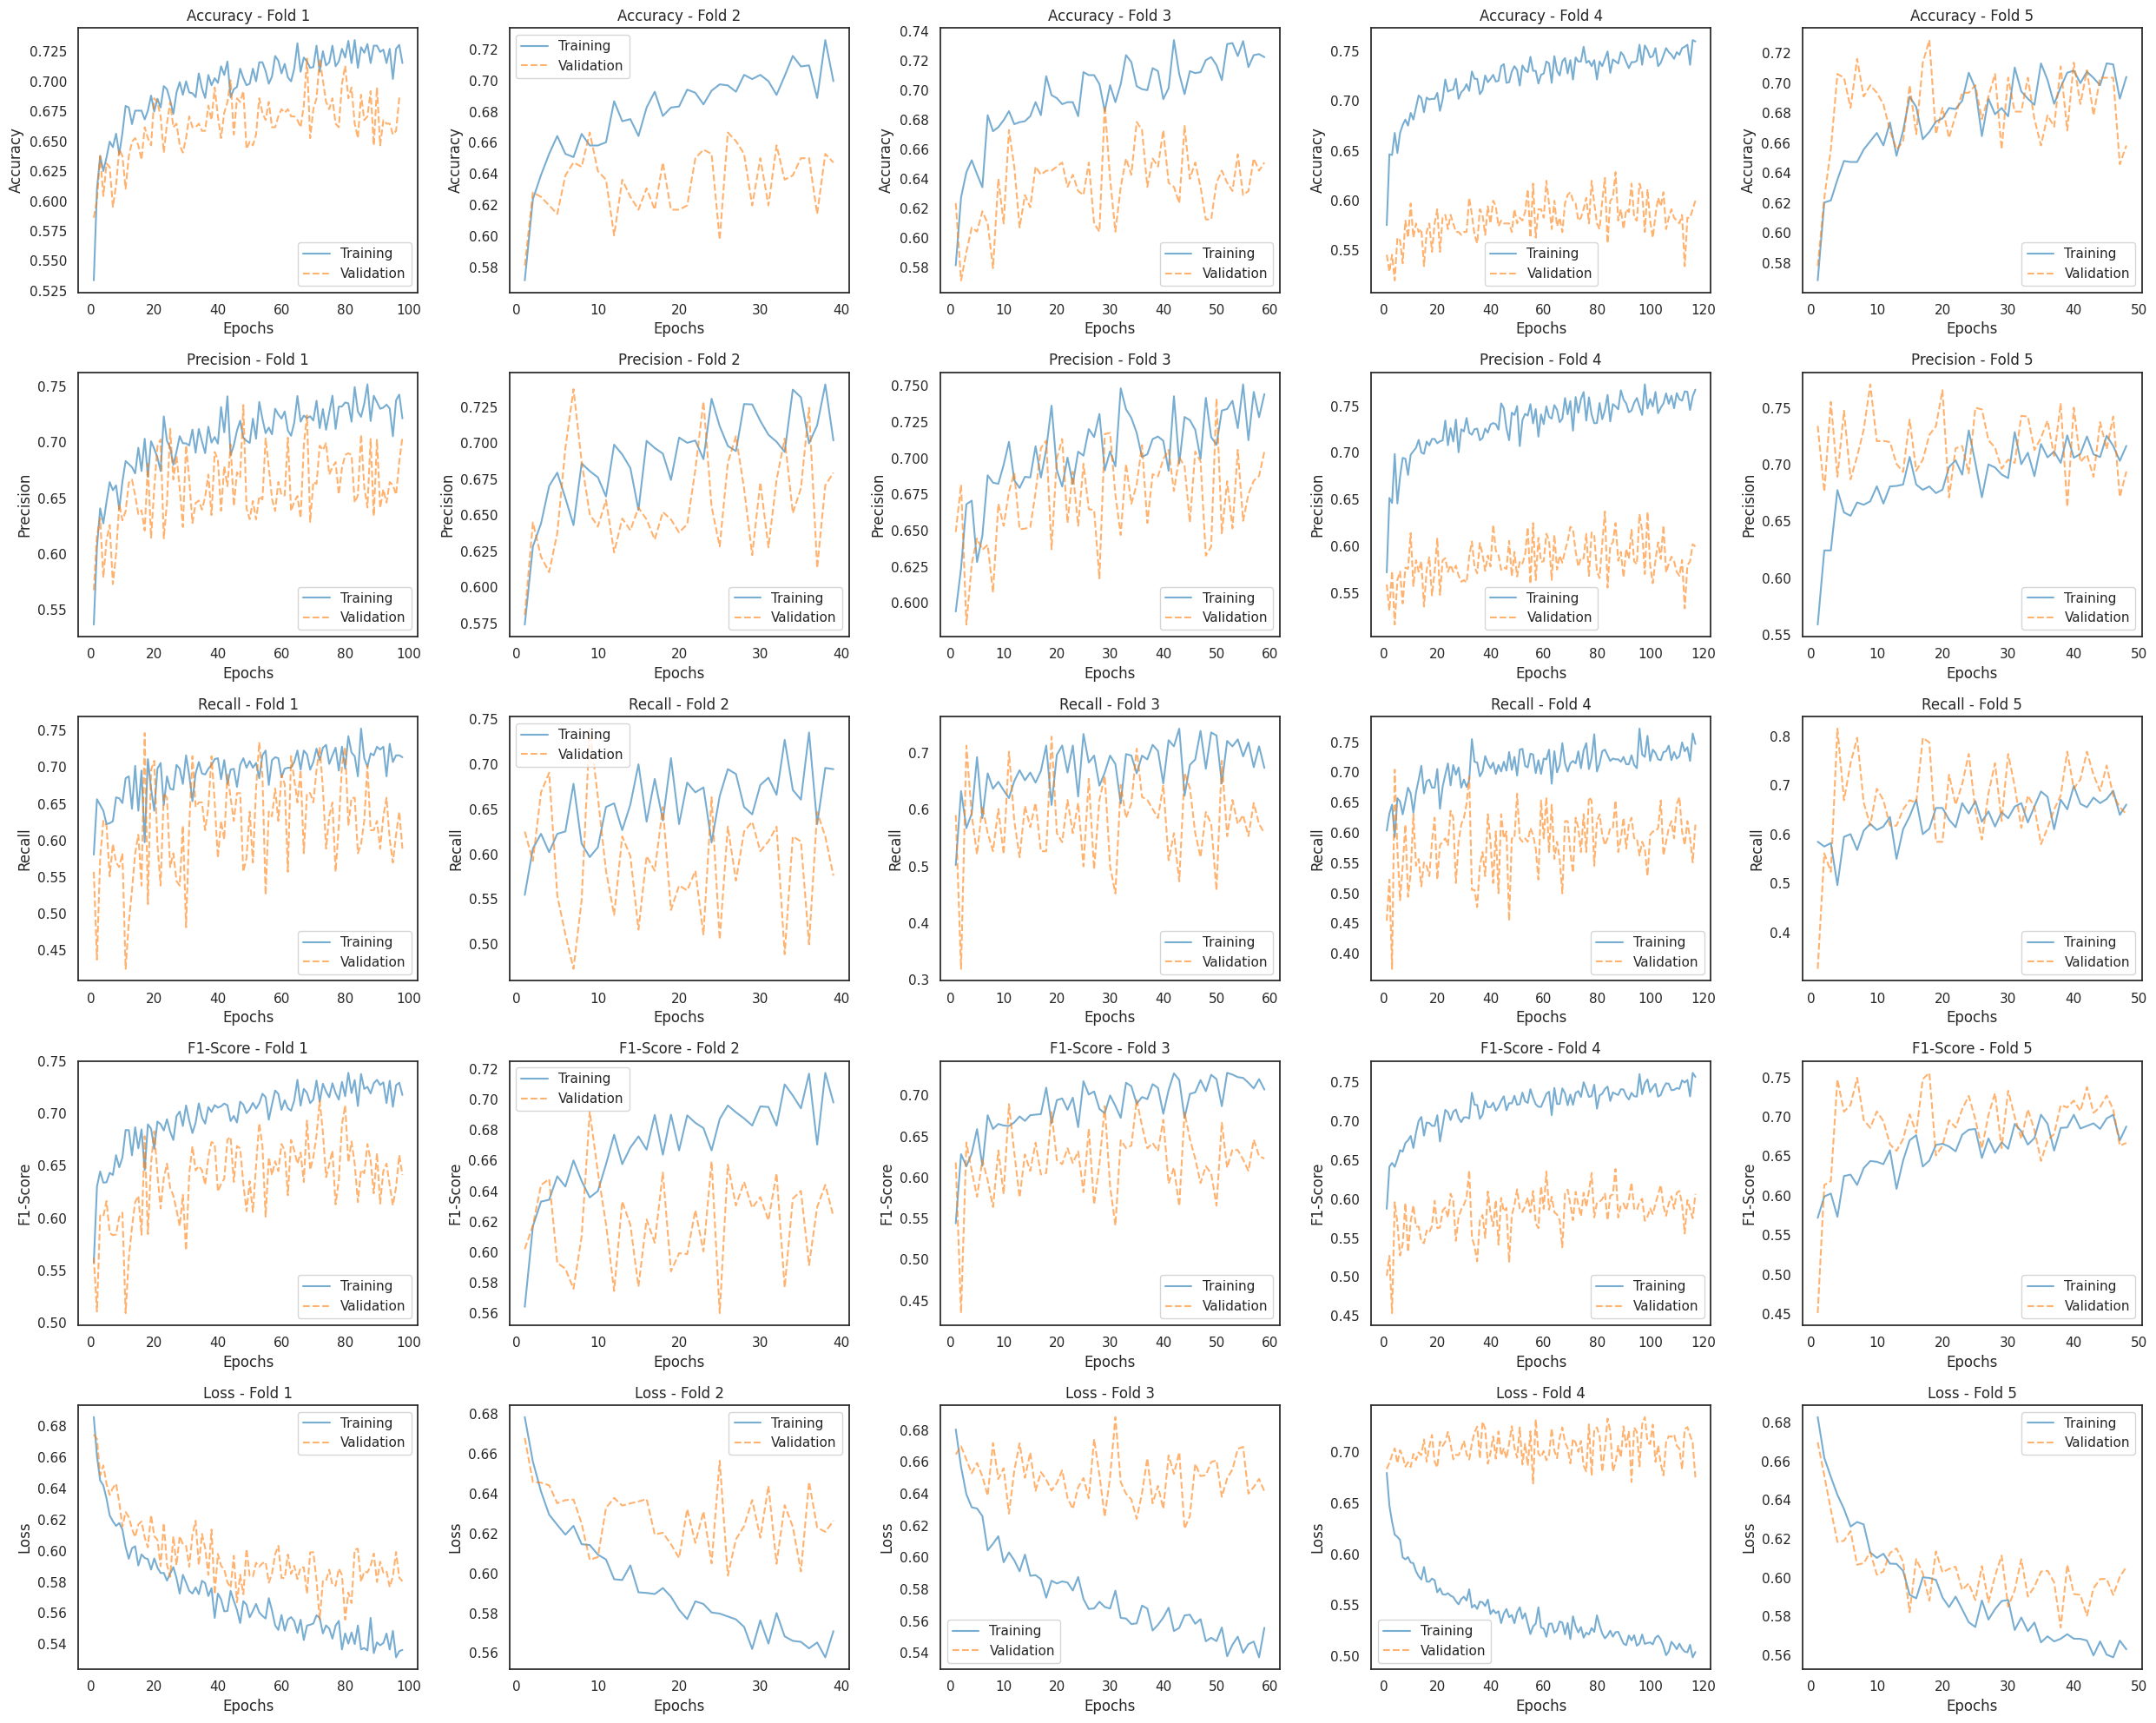

In [ ]:
# Section 8: Results and Visualization

# Plotting function for fold metrics
def plot_fold_metrics(train_metrics, val_metrics, metric_name, fold_num, subplot_position):
    plt.subplot(5, 5, subplot_position)
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, label=f'Training', alpha=0.6)
    plt.plot(epochs, val_metrics, label=f'Validation', alpha=0.6, linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend(loc='best')
    plt.title(f'{metric_name} - Fold {fold_num}')

# Plot accuracies and other metrics across all folds
print("Plotting results...")
plt.figure(figsize=(25, 20))

# Plotting Training and Validation Accuracy for each fold
for fold_num, fold_result in enumerate(fold_results, 1):
    plot_fold_metrics(fold_result['train_accuracy'], fold_result['val_accuracy'], 'Accuracy', fold_num, fold_num)

# Plotting Training and Validation Precision for each fold
for fold_num, fold_result in enumerate(fold_results, 1):
    plot_fold_metrics(fold_result['train_precision'], fold_result['val_precision'], 'Precision', fold_num, fold_num + 5)

# Plotting Training and Validation Recall for each fold
for fold_num, fold_result in enumerate(fold_results, 1):
    plot_fold_metrics(fold_result['train_recall'], fold_result['val_recall'], 'Recall', fold_num, fold_num + 10)

# Plotting Training and Validation F1-Score for each fold
for fold_num, fold_result in enumerate(fold_results, 1):
    plot_fold_metrics(fold_result['train_f1'], fold_result['val_f1'], 'F1-Score', fold_num, fold_num + 15)

# Plotting Training and Validation Loss for each fold
for fold_num, fold_result in enumerate(fold_results, 1):
    plot_fold_metrics(fold_result['train_loss'], fold_result['val_loss'], 'Loss', fold_num, fold_num + 20)

plt.tight_layout()
plt.show()


<ipython-input-13-ded3547fb947>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=levels, y=mean_probs, palette='Blues_d')


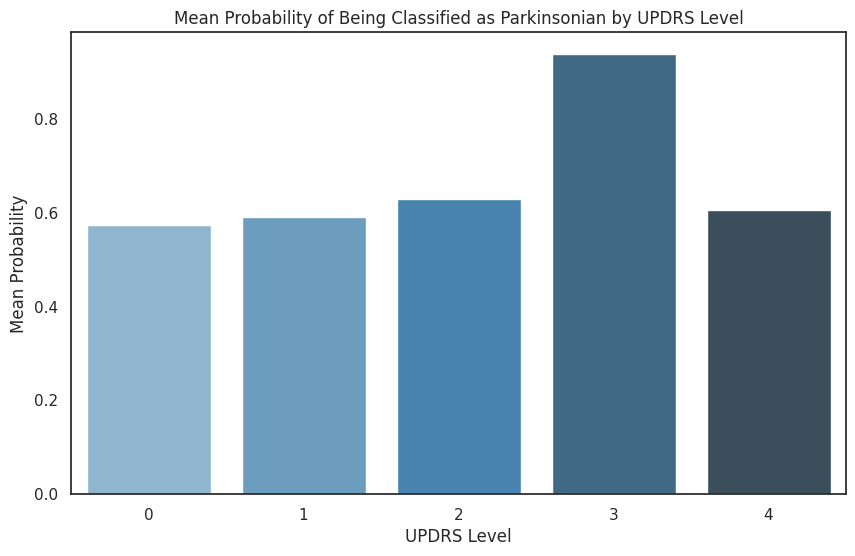

<ipython-input-13-ded3547fb947>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='UPDRS Level', y='Probability', data=df, palette='Pastel1')


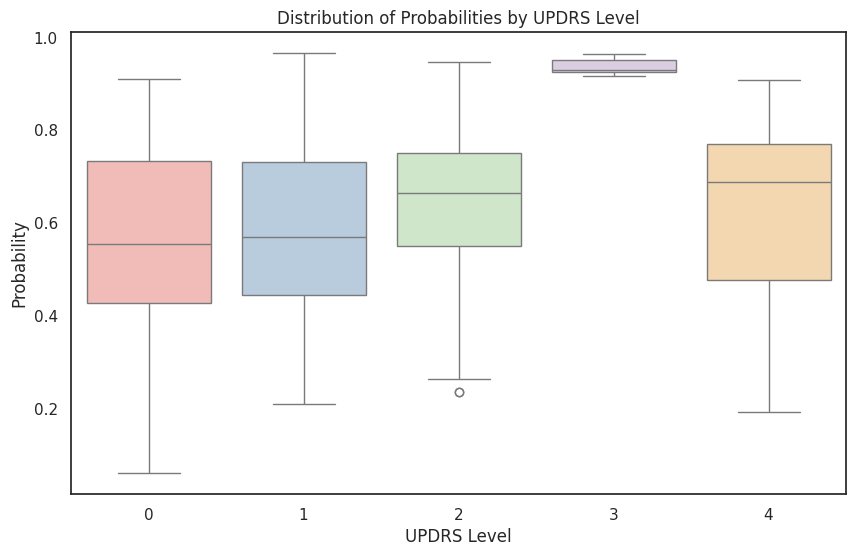

<ipython-input-13-ded3547fb947>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=levels, y=percentages_classified, palette='Oranges_d')


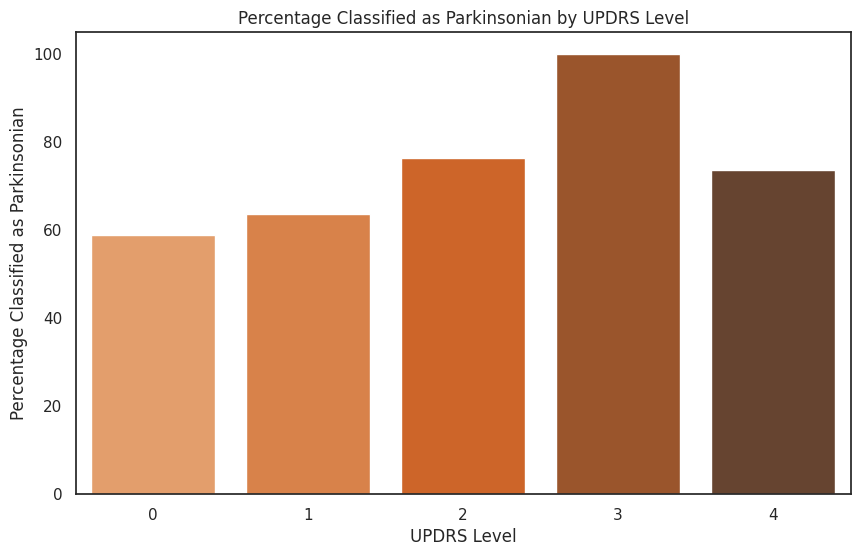

<ipython-input-13-ded3547fb947>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=levels, y=total_counts, palette='Greens_d')


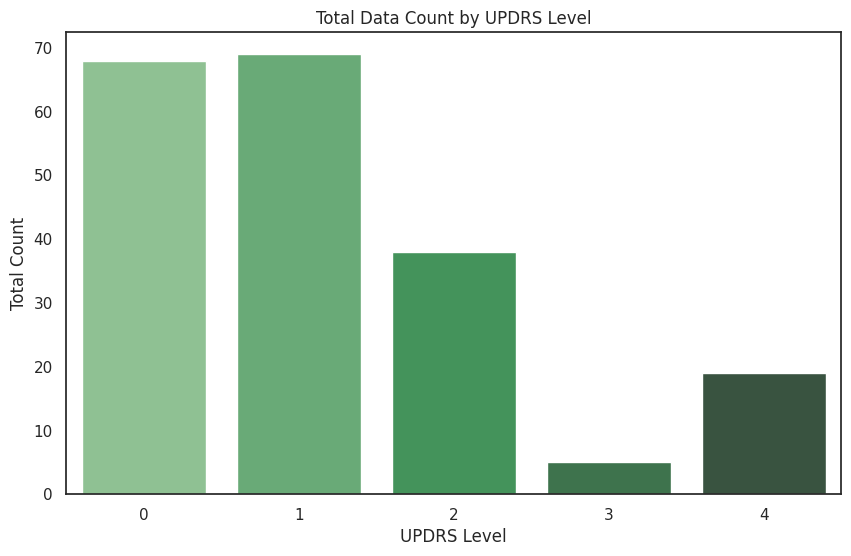

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_updrs_metrics(aggregated_updrs_metrics, probabilities_by_updrs):
    # Prepare data for plotting
    levels = list(aggregated_updrs_metrics.keys())
    total_counts = [aggregated_updrs_metrics[level]['total_count'] for level in levels]
    mean_probs = [aggregated_updrs_metrics[level]['mean_probability'] for level in levels]
    mean_logits = [aggregated_updrs_metrics[level]['mean_logit'] for level in levels]
    percentages_classified = [aggregated_updrs_metrics[level]['percentage_classified_as_parkinsonian'] for level in levels]

    # Bar chart for mean probabilities
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=mean_probs, palette='Blues_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Mean Probability')
    plt.title('Mean Probability of Being Classified as Parkinsonian by UPDRS Level')
    plt.show()

    # Boxplot for probabilities
    plt.figure(figsize=(10, 6))
    data = [(level, prob) for level, probs in probabilities_by_updrs.items() for prob in probs]
    df = pd.DataFrame(data, columns=['UPDRS Level', 'Probability'])
    sns.boxplot(x='UPDRS Level', y='Probability', data=df, palette='Pastel1')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Probability')
    plt.title('Distribution of Probabilities by UPDRS Level')
    plt.show()

    # Bar chart for percentage classified as Parkinsonian
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=percentages_classified, palette='Oranges_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Percentage Classified as Parkinsonian')
    plt.title('Percentage Classified as Parkinsonian by UPDRS Level')
    plt.show()

    # Bar chart for total count
    plt.figure(figsize=(10, 6))
    sns.barplot(x=levels, y=total_counts, palette='Greens_d')
    plt.xlabel('UPDRS Level')
    plt.ylabel('Total Count')
    plt.title('Total Data Count by UPDRS Level')
    plt.show()

# Call the function after calculating metrics
plot_updrs_metrics(aggregated_updrs_metrics, probabilities_by_updrs)


In [ ]:
# Nome del file per salvare tutti i risultati
results_filename = "results_ViT.txt"

# Scrivi tutti i risultati in un unico file
with open(results_filename, mode="w") as file:
    # Scrivi i risultati UPDRS
    file.write("===== Aggregated UPDRS Metrics Across Folds =====\n")
    for level, metrics in aggregated_updrs_metrics.items():
        file.write(f"UPDRS Level {level}:\n")
        file.write(f"  Total Count: {metrics['total_count']}\n")
        file.write(f"  Mean Probability (Parkinsonian): {metrics['mean_probability']:.4f}\n")
        file.write(f"  Percentage Classified as Parkinsonian: {metrics['percentage_classified_as_parkinsonian']:.2f}%\n")
        file.write("-" * 40 + "\n")

    # Scrivi le metriche medie sui fold
    file.write("\n===== Average Metrics Across Folds (Last Epoch Only) =====\n")
    file.write(f"Training Accuracy: {average_train_accuracy:.4f}\n")
    file.write(f"Validation Accuracy: {average_val_accuracy:.4f}\n")
    file.write(f"Training Precision: {average_train_precision:.4f}\n")
    file.write(f"Validation Precision: {average_val_precision:.4f}\n")
    file.write(f"Training Recall: {average_train_recall:.4f}\n")
    file.write(f"Validation Recall: {average_val_recall:.4f}\n")
    file.write(f"Training F1-Score: {average_train_f1:.4f}\n")
    file.write(f"Validation F1-Score: {average_val_f1:.4f}\n")
    file.write(f"Validation Sensitivity: {average_val_sensitivity:.4f}\n")
    file.write(f"Validation Specificity: {average_val_specificity:.4f}\n")

print(f"All results saved to {results_filename}")


All results saved to results_ViT.txt
